In [67]:
from __future__ import print_function, division
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
%matplotlib inline
warnings.filterwarnings('ignore')

In [69]:
train = pd.read_csv("../bases/train.csv").set_index("id")
test = pd.read_csv("../bases/test.csv").set_index("id")
df = train.append(test)

# EDA

## Locations
has a high cardinality that we need to treat changing maybe to a word2vec, but we can't group automatically for now, so we won't use it for now

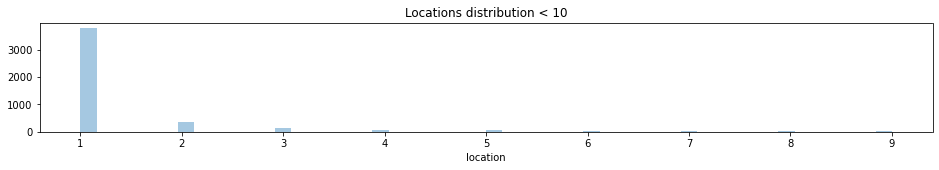

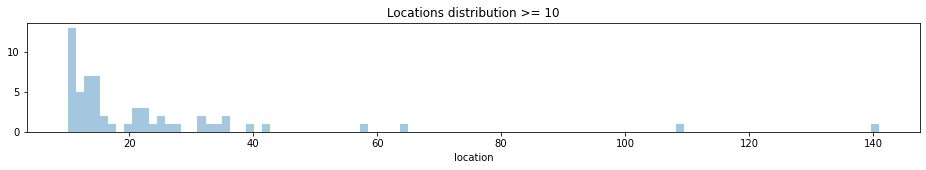

In [32]:
locations = df.location.value_counts()
plt.figure(figsize=(16,2))
plt.title("Locations distribution < 10")
sns.distplot(locations[locations < 10],kde=False)
plt.show()

plt.figure(figsize=(16,2))
plt.title("Locations distribution >= 10")
sns.distplot(locations[locations >= 10],kde=False,bins=100)
plt.show()

## Keywords
we see that the have some %20 that needs to be replaced by whitespace, bag of words can handle here

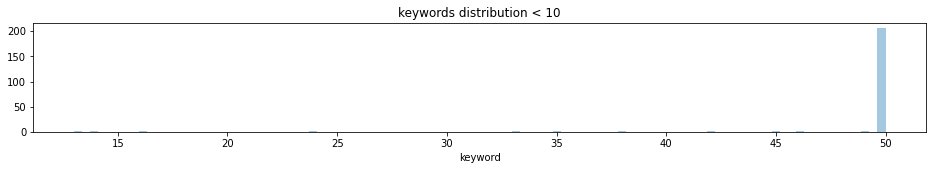

debris                   50
quarantine               50
emergency%20plan         50
crashed                  50
burning                  50
                         ..
forest%20fire            24
threat                   16
inundation               14
radiation%20emergency    14
epicentre                13
Name: keyword, Length: 221, dtype: int64

In [33]:
keywords = df.keyword.value_counts()
plt.figure(figsize=(16,2))
plt.title("keywords distribution < 10")
sns.distplot(keywords,kde=False,bins=100)
plt.show()
keywords

## Texts
a first impression is that we have repited values for texts and they are from different languages
- we do have racists words (?????)
- repited dots (.... or ??????)
- we do have links, should we replace then?
- probably the quotes signals and the punctuation matters here

In [25]:
texts = df.text.value_counts()
texts.sample(20)

@Reuters people like you should be charged after the inevitable rioting for contributing to it with your lies                                    1
lets see how good you are at soccer when you're bleeding out yo face                                                                             1
The last time a high profile name was due to be signing for #nffc the City was rioting! Wesley Verhoek now a household name! #don'tpanic         1
Dramatic Video Shows Plane Landing During Violent Storm http://t.co/rJ9gkJKJJn                                                                   1
RT @calestous: Tanzania elephant population declined by 60% in five years census reveals http://t.co/8zy9N6fX9T http://t.co/ITZ9masBvZ           1
#LonePine remembered around Australia as 'descendants' grow via @666canberra #Gallipoli #WW1\nhttp://t.co/bwadX8ywqN http://t.co/UPFjy88KvI      1
HereÛªs what caused a Metro train to derail in downtown D.C. http://t.co/ImTYgdS5qO                                  

## Target
we have more non desasters (57%) and the other features with non nulls are not statistiscally significant to be used

In [28]:
df.target.value_counts(normalize=True)

0.0    0.57034
1.0    0.42966
Name: target, dtype: float64

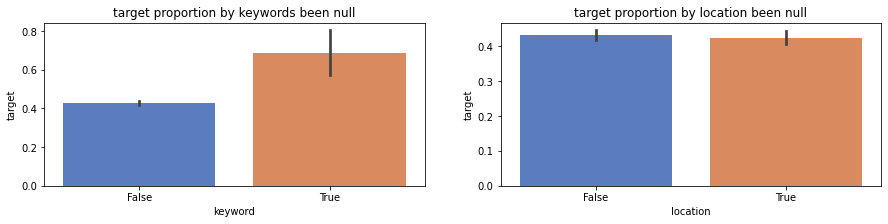

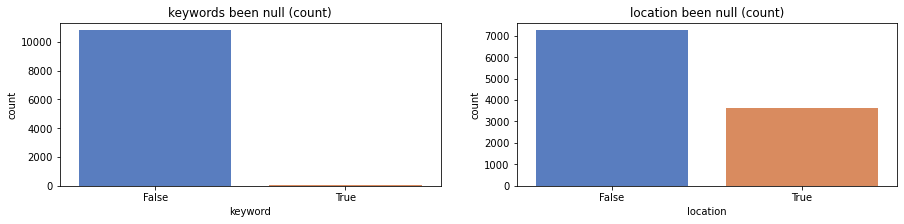

In [46]:
f, axs = plt.subplots(1,2,figsize=(15,3))

axs[0].set_title("target proportion by keywords been null")
sns.barplot(df.keyword.isna(),df.target,ax=axs[0],palette="muted")

axs[1].set_title("target proportion by location been null")
sns.barplot(df.location.isna(),df.target,palette="muted",ax=axs[1])
plt.show()


f, axs = plt.subplots(1,2,figsize=(15,3))

axs[0].set_title("keywords been null (count)")
sns.countplot(df.keyword.isna(),ax=axs[0],palette="muted")

axs[1].set_title("location been null (count)")
sns.countplot(df.location.isna(),ax=axs[1],palette="muted")
plt.show()

# Data treatment
we will use just the text and the keywords in this model, location cannot be treated with bag of words, requires external datasets that we don't have for now

> later notes:
build a crawler to look in the google the position of those locations and use the coordenates and get their main language

In [ ]:
from nltk.stem.snowball import SnowballStemmer # supports porguese,english...
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
stemmer = SnowballStemmer('english')

## Location

In [49]:
df.drop("location",axis=1,inplace=True)
#df['location'].fillna("Unknown",inplace=True)

## keywords

In [70]:
df['keyword'].fillna("Unknown",inplace=True)

print(f"unique keywords: {df['keyword'].nunique()}")
      
df['keyword'] = df['keyword'].str.lower()
print(f"(lower) unique keywords: {df['keyword'].nunique()}")

regex = re.compile("%20")
df['keyword'] = df['keyword'].apply(lambda x: regex.sub(" ",str(x)))

df['keyword'] = df['keyword'].apply(lambda x: " ".join([stemmer.stem(word) for word in str(x).split(" ")]) )
print(f"(stemmer) unique keywords: {df['keyword'].nunique()}")
      


unique keywords: 222
(lower) unique keywords: 222
(stemmer) unique keywords: 167


In [75]:
vectorizer = CountVectorizer()
keywords_bag = vectorizer.fit_transform(df['keyword'].values)
print(keywords_bag.shape)

(10876, 176)


## Text

In [78]:
col = 'text'

df[col].fillna("",inplace=True)
print(f"unique {col}: {df['text'].nunique()}")
      

      
df[col] = df[col].str.lower()
print(f"(lower) unique {col}: {df[col].nunique()}")

regex = re.compile("%20")
df[col] = df[col].apply(lambda x: regex.sub(" ",str(x)))

df[col] = df[col].apply(lambda x: " ".join([stemmer.stem(word) for word in str(x).split(" ")]) )
print(f"(stemmer) unique {col}: {df[col].nunique()}")
      


unique text: 10678


In [107]:
vectorizer = CountVectorizer(min_df=50)
texts_bag = vectorizer.fit_transform(df[col].values)
print(texts_bag.shape)

(10876, 469)


## unify the bag of words

In [115]:
from scipy.sparse import hstack
data = hstack((texts_bag,keywords_bag))

# Validation Schema
--- 
for the first model we won't build to validate

In [136]:
x_train,y_train = data.todense()[:train.shape[0]],train.target.values
x_test = data.todense()[train.shape[0]:]

In [129]:
from sklearn.model_selection import train_test_split

# Modelling

In [138]:
from sklearn.linear_model import LogisticRegression

In [140]:
clf = LogisticRegression(solver='lbfgs')
clf.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [141]:
y_test = clf.predict(x_test)

# Output

In [163]:
output = pd.Series(index=test.index,data=y_test).to_frame('target').reset_index()
print(output['target'].mean())


0.3711308611707018


In [165]:
file_name = f"../output/{str(datetime.today().date())} LR.csv"
output.to_csv(file_name,index=False)